In [1]:
%matplotlib inline
import os
from PIL import Image
import matplotlib.pyplot as plt

# this is nemo's "core" package
import nemo
# this is nemos's collection of GAN-related modules used for this example
import nemo_simple_gan

In [2]:
# Define model parameters
batch_size = 64
data_root = "."

### Instantiate necessary Neural Modules

In [3]:
mnist_data = nemo_simple_gan.MnistGanDataLayer(
    batch_size=batch_size,
    shuffle=True,
    train=True,
    root=data_root
)

In [4]:
generator = nemo_simple_gan.SimpleGenerator(batch_size=batch_size)

In [5]:
discriminator = nemo_simple_gan.SimpleDiscriminator()

In [6]:
interpolater = nemo_simple_gan.InterpolateImage()

In [7]:
# Loss_D = D(interpolated) - D(real) + lambda * GP
disc_loss = nemo_simple_gan.DiscriminatorLoss()
neg_disc_loss = nemo_simple_gan.DiscriminatorLoss(neg=True)

In [8]:
disc_grad_penalty = nemo_simple_gan.GradientPenalty(lambda_=10)

### Describe how Neural Modules are connected together

In [9]:
# Create generator DAG
# Grab data from data layer
latents, real_data, _ = mnist_data()
# Generate image from latents
generated_image = generator(latents=latents)
# Define D(G(z)) where z represents the latents
# generator_decision is a tensor that represents D(G(z))
generator_decision = discriminator(image=generated_image)
# Define loss_G = - mean(D(G(z)))
generator_loss = neg_disc_loss(decision=generator_decision)

In [10]:
# Create discriminator DAG
# Create interpolated image that is somewhere inbetween the real_image
# and the generated image
# Note: we reuse the generated_image tensor from the generator DAG
interpolated_image = interpolater(image1=real_data, image2=generated_image)
# Define D(x~) where x~ is the interpolated image
interpolated_decision = discriminator(image=interpolated_image)
# Define D(x) where x is the real image
real_decision = discriminator(image=real_data)

# Define the components of the discriminator loss
# interpolated_loss = mean(D(x~))
interpolated_loss = disc_loss(decision=interpolated_decision)
# real_loss = - mean(D(x))
real_loss = neg_disc_loss(decision=real_decision)
# grad_penalty = mean(lambda* (|gradients| - 1) ** 2)
grad_penalty = disc_grad_penalty(
    interpolated_image=interpolated_image,
    interpolated_decision=interpolated_decision)
# Note the final loss_D = interpolated_loss + real_loss + grad_penalty

In [11]:
# Create Eval DAG
# Create a new datalayer that samples from the latent distribution
random_data = nemo_simple_gan.RandomDataLayer(batch_size=batch_size)
# Create a new NmTensor to get data from the data layer
latents_e = random_data()
# Generate from latents
generated_image_e = generator(latents=latents_e)

### Run training

In [12]:
# Create a neural factory
neural_factory = nemo.core.NeuralModuleFactory(backend=nemo.core.Backend.PyTorch)
trainer = neural_factory._trainer
# Define the losses
losses_G = [generator_loss]
losses_D = [interpolated_loss, real_loss, grad_penalty]

In [13]:
# Since we want optimizers to only operate on a subset of the model, we need
# to manually create optimizers
# For single loss and single optimizer, the following steps can be skipped
# and an optimizer will be created in trainer.train()
optimizer_G = trainer.create_optimizer(
    optimizer="adam",
    things_to_optimize=[generator],
    optimizer_params={
        "lr": 1e-4,
        "betas": (0.5, 0.9),
    })
optimizer_D = trainer.create_optimizer(
    optimizer="adam",
    things_to_optimize=[discriminator],
    optimizer_params={
        "lr": 1e-4,
        "betas": (0.5, 0.9),
    })

In [14]:
# Define some helper functions to log generated samples
def save_image(global_vars):
    images = global_vars["image"]
    image = images[0].squeeze(0).detach().cpu().numpy() * 255
    plt.imshow(image, cmap="gray")
    plt.show()


def put_tensor_in_dict(tensors, global_vars):
    global_vars["image"] = tensors[generated_image_e.unique_name][0]

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Doing Evaluation ..............................


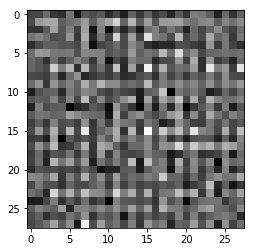

Evaluation time: 1.2685503959655762 seconds
Doing Evaluation ..............................


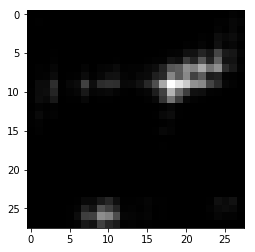

Evaluation time: 1.210198163986206 seconds
Doing Evaluation ..............................


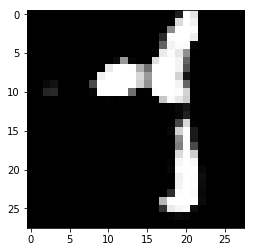

Evaluation time: 1.2725772857666016 seconds
Doing Evaluation ..............................


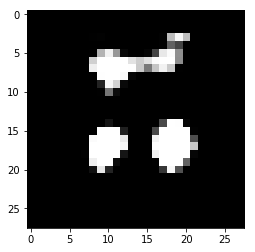

Evaluation time: 1.2323925495147705 seconds
Doing Evaluation ..............................


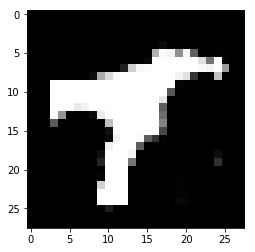

Evaluation time: 1.268960952758789 seconds
Doing Evaluation ..............................


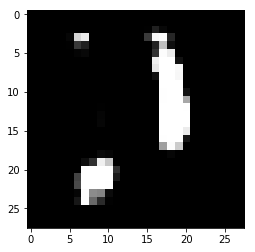

Evaluation time: 1.2771921157836914 seconds
Doing Evaluation ..............................


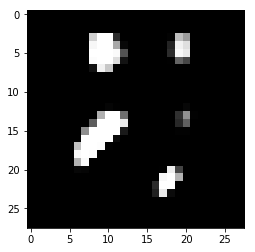

Evaluation time: 1.2810349464416504 seconds
Doing Evaluation ..............................


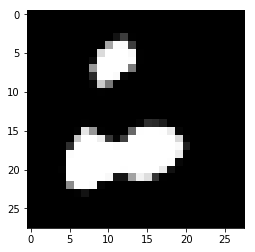

Evaluation time: 1.354567289352417 seconds
Doing Evaluation ..............................


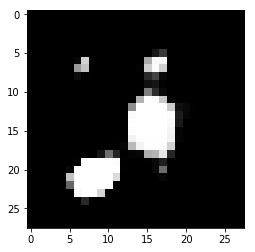

Evaluation time: 1.2980642318725586 seconds
Doing Evaluation ..............................


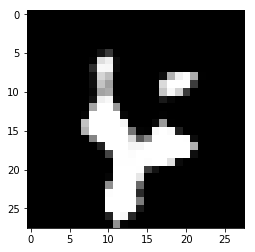

Evaluation time: 1.2718994617462158 seconds
Final Evaluation ..............................


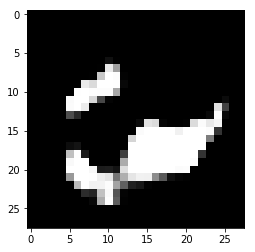

In [15]:
# Define a callback that generates samples
eval_callback = nemo.core.EvaluatorCallback(
    eval_tensors=[generated_image_e],
    user_iter_callback=put_tensor_in_dict,
    user_epochs_done_callback=lambda x: save_image(x),
    eval_step=1000,
)

# Define our training loop. Here we optimize take 3 discriminator steps
# prior to taking the generator step
tensors_to_optimize = [
    (optimizer_D, losses_D),
    (optimizer_D, losses_D),
    (optimizer_D, losses_D),
    (optimizer_G, losses_G),
]

# Finally, call train with our training loop and callbacks
trainer.train(
    tensors_to_optimize=tensors_to_optimize,
    callbacks=[eval_callback],
    optimization_params={"num_epochs": 10})